# Exploring `add_electricity.py` outputs

This jupyter notebook analyse the `add_electricity.py` **outputs**.

The `pypsa-africa/Snakefile` explicitly list in the **rule** what goes into the function `add_electricity.py` and what goes out (`elec.nc`). When inputs are commented out (#) than they are currently not considered. Maybe you want to make them run or develop new features? What can be observed from the inputs is that the script adds electrical generators, existing hydro storage, renewable generator profiles and loads units to a base network topology.

```
rule add_electricity:
    input:
        base_network='networks/base.nc',
        tech_costs=COSTS,
        regions="resources/regions_onshore.geojson",
        powerplants='resources/powerplants.csv',
        # hydro_capacities='data/bundle/hydro_capacities.csv',
        # geth_hydro_capacities='data/geth2015_hydro_capacities.csv',
        load='resources/ssp2-2.6/2030/era5_2013/Africa.nc',
        gadm_shapes='resources/gadm_shapes.geojson',
        **{f"profile_{tech}": f"resources/profile_{tech}.nc"
            for tech in config['renewable']}
    output: "networks/elec.nc"
    log: "logs/add_electricity.log"
    benchmark: "benchmarks/add_electricity"
    threads: 1
    resources: mem=3000
    script: "scripts/add_electricity.py"
```

Before analysing the outputs of add_electricity.py check that:
- `pypsa-africa` environment (/kernel) in jupyter notebook  is active and updated
- root folder where pypsa-africa is installed is named "pypsa-africa"
- or rename the below `sets_path_to_root("<folder_name>")` accordingly

In [1]:
import sys
sys.path.append('../')  # to import helpers
from scripts._helpers import sets_path_to_root
sets_path_to_root("pypsa-africa")

This is the repository path:  /home/max/OneDrive/PHD-Flexibility/07_pypsa-africa/0github/pypsa-africa/pypsa-africa
Had to go 1 folder(s) up.


A jupyter notebook requires the user to import all they need. So we need to import all the required dependencies from the `pypsa-africa` environment:

In [2]:
import logging
import os

import pypsa
import yaml
import pandas as pd
import geopandas as gpd
#import geoviews as gv
#import hvplot.pandas
import numpy as np
import scipy as sp
import networkx as nx
import matplotlib as plt

from scipy.sparse import csgraph
from itertools import product

from shapely.geometry import Point, LineString
import shapely, shapely.prepared, shapely.wkt

logger = logging.getLogger(__name__)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 70)

## Network analysis

Now let's import the output file which should be in i.e. `~/pypsa-africa/networks/elec.nc`. 

Note: If you don't have the /elec.nc file yet in your folder structure, you could try to generate it from the terminal. In this case set the path so that you are located at `~/pypsa-africa`. Once you are there, use the command:
```
snakemake -j 1 networks/elec.nc
```
Note that this is something you can to for any other rule to generate it's outputs `snakemake -j 1 <output of rule>`

In [3]:
network_path = os.getcwd() + "/networks/elec.nc"
n = pypsa.Network(network_path)
n

Importing PyPSA from older version of PyPSA than current version.
Please read the release notes at https://pypsa.org/doc/release_notes.html
carefully to prepare your network for import. 
Currently used PyPSA version [0, 18, 1], imported network file PyPSA version [0, 18, 0].

INFO:pypsa.io:Imported network elec.nc has buses, carriers, generators, lines, loads


Network PyPSA-Eur

You might be interested to see what's in the Network Common Data Form or NetCDF (.nc) file. To assess that we use **xarray**

In [5]:
import xarray as xr

path = os.getcwd() + "/networks/elec.nc"
network_data = xr.open_dataset(path)

network_data

<xarray.Dataset>
Dimensions:                       (snapshots: 8760, investment_periods: 0, lines_i: 1241, generators_i: 492, generators_t_p_max_pu_i: 492, loads_i: 247, loads_t_p_set_i: 247, buses_i: 992, carriers_i: 4)
Coordinates:
  * snapshots                     (snapshots) int64 0 1 2 3 ... 8757 8758 8759
  * investment_periods            (investment_periods) float64 
  * lines_i                       (lines_i) object '672356932-1' ... 'link   ...
  * generators_i                  (generators_i) object '12 onwind' ... '535 ...
  * generators_t_p_max_pu_i       (generators_t_p_max_pu_i) object '0 onwind'...
  * loads_i                       (loads_i) object '0' '1' '2' ... '948' '966'
  * loads_t_p_set_i               (loads_t_p_set_i) object '18' '19' ... '966'
  * buses_i                       (buses_i) object '0' '1' '2' ... '990' '991'
  * carriers_i                    (carriers_i) object 'onwind' ... 'solar'
Data variables: (12/52)
    snapshots_snapshot            (snapshots) datetime64[ns] ...
    snapshots_objective           (snapshots) float64 ...
    snapshots_generators          (snapshots) float64 ...
    snapshots_stores              (snapshots) float64 ...
    investment_periods_objective  (investment_periods) float64 ...
    investment_periods_years      (investment_periods) float64 ...
    ...                            ...
    buses_substation_lv           (buses_i) bool ...
    buses_x                       (buses_i) float64 ...
    buses_y                       (buses_i) float64 ...
    buses_substation_off          (buses_i) bool ...
    carriers_color                (carriers_i) object ...
    carriers_nice_name            (carriers_i) object ...
Attributes:
    network_name:           PyPSA-Eur
    network_pypsa_version:  0.18.0
    network_srid:           4326

A quick check of the network topology:

/home/max/anaconda3/envs/pypsa-africa/lib/python3.9/site-packages/pypsa/plot.py:149: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = plt.gca(projection=projection)


(<matplotlib.collections.PatchCollection at 0x7f15b0c855e0>,
 <matplotlib.collections.LineCollection at 0x7f15b0a907c0>)

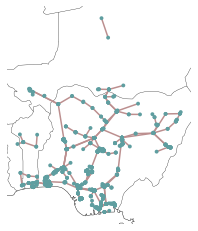

In [7]:
n.plot()

A full list of components are given: https://pypsa.readthedocs.io/en/latest/components.html#
We always check the PyPSA documentation to find analyse the components of interest.

In [6]:
n.buses.head(4)

,v_nom,symbol,under_construction,tag_substation,tag_area,lon,lat,country,substation_lv,x,y,substation_off,type,carrier,unit,v_mag_pu_set,v_mag_pu_min,v_mag_pu_max,control,sub_network
name,,,,,,,,,,,,,,,,,,,,
0,220.0,False,False,False,False,2.084339,13.564081,NE,True,2.084339,13.564081,True,,AC,None,1.0,0.0,inf,PQ,
1,220.0,False,False,False,False,2.335772,13.318281,NE,True,2.335772,13.318281,True,,AC,None,1.0,0.0,inf,PQ,
2,220.0,False,False,False,False,2.142144,13.477309,NE,True,2.142144,13.477309,True,,AC,None,1.0,0.0,inf,PQ,
3,220.0,False,False,False,False,7.355982,18.711053,NE,True,7.355982,18.711053,True,,AC,None,1.0,0.0,inf,PQ,


In [5]:
n.lines.head(2)

,bus0,bus1,v_nom,num_parallel,length,underground,under_construction,tag_type,tag_frequency,country,geometry,bounds,bus0_lon,bus0_lat,bus1_lon,bus1_lat,bus_0_coors,bus_1_coors,type,s_max_pu,s_nom,x,r,g,b,s_nom_extendable,s_nom_min,s_nom_max,capital_cost,build_year,lifetime,carrier,terrain_factor,v_ang_min,v_ang_max,sub_network,x_pu,r_pu,g_pu,b_pu,x_pu_eff,r_pu_eff,s_nom_opt
name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
381266480-1,0,10323,220.0,1.0,46.739566,False,False,line,50,DZ,"LINESTRING (-0.1903026 35.76851289999971, -0.1861734 35.7674756999...","MULTIPOINT (-0.1903026 35.76851289999971, 0.1378516 35.87824859999...",-0.190303,35.768513,0.137852,35.878249,NaN,NaN,Al/St 240/40 2-bundle 220.0,0.7,491.556019,0.0,0.0,0.0,0.0,False,0.0,inf,0.0,0,inf,,1.0,-inf,inf,,0.0,0.0,0.0,0.0,0.0,0.0,0.0
381141189-1,1,10324,220.0,2.0,3.115450,False,False,line,50,DZ,"LINESTRING (-0.395014 35.5345674999999, -0.3943208 35.533282099999...","MULTIPOINT (-0.395014 35.5345674999999, -0.3749039 35.5425093)",-0.395014,35.534567,-0.374904,35.542509,NaN,NaN,Al/St 240/40 2-bundle 220.0,0.7,983.112038,0.0,0.0,0.0,0.0,False,0.0,inf,0.0,0,inf,,1.0,-inf,inf,,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
# The maximal available power output
n.generators.groupby("carrier").p_nom_max.sum() / 1e3 # converted in [GW]

carrier
onwind    3232.4184
solar     3232.4184
Name: p_nom_max, dtype: float64

In [13]:
# The (by the model) optimised installed power 
n.generators.groupby("carrier").p_nom_opt.sum() / 1e3  # converted in [GW]

carrier
onwind    0.0
solar     0.0
Name: p_nom_opt, dtype: float64

### Maximal available wind profile (as p.u.)

A time series is of the type of "series". See: https://pypsa.readthedocs.io/en/latest/components.html#generator
This requires to use `n.generator_t.p_max_pu` instead `n.generator.p_max_pu`

<AxesSubplot:xlabel='snapshot'>

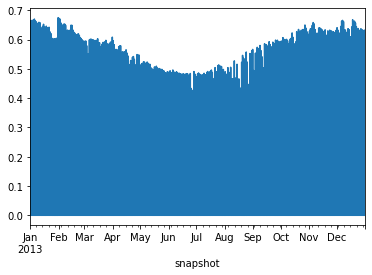

In [14]:
n.generators_t.p_max_pu.iloc[:,0].plot()

# Load timeseries


In [20]:
n.loads_t.p

""
snapshot
2013-01-01 00:00:00
2013-01-01 01:00:00
2013-01-01 02:00:00
2013-01-01 03:00:00
2013-01-01 04:00:00
...
2013-12-31 19:00:00
2013-12-31 20:00:00
2013-12-31 21:00:00
